In [1]:
import sys
import os

# Add the parent directory (project root) to sys.path
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob

In [3]:
df = pd.read_csv('../data/raw_analyst_ratings.csv')

In [4]:
df.isnull().sum()

Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

In [5]:
# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Add a headline length column
df['headline_length'] = df['headline'].astype(str).apply(len)

# Add weekday column
df['weekday'] = df['date'].dt.day_name()

In [6]:
print(df['headline_length'].describe())

count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


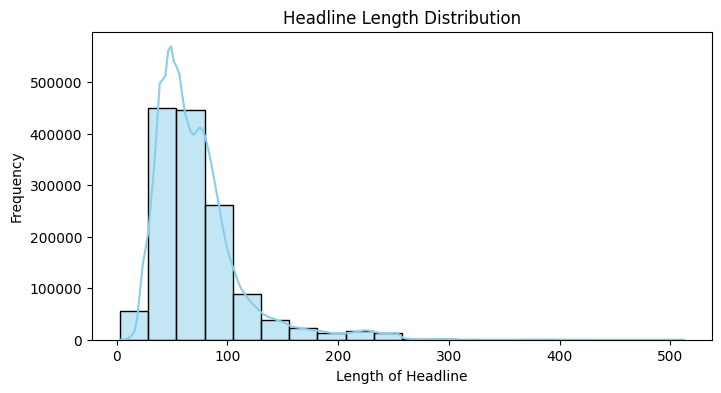

In [7]:
plt.figure(figsize=(8, 4))
sns.histplot(df['headline_length'], bins=20, kde=True, color='skyblue')
plt.title('Headline Length Distribution')
plt.xlabel('Length of Headline')
plt.ylabel('Frequency')
plt.show()

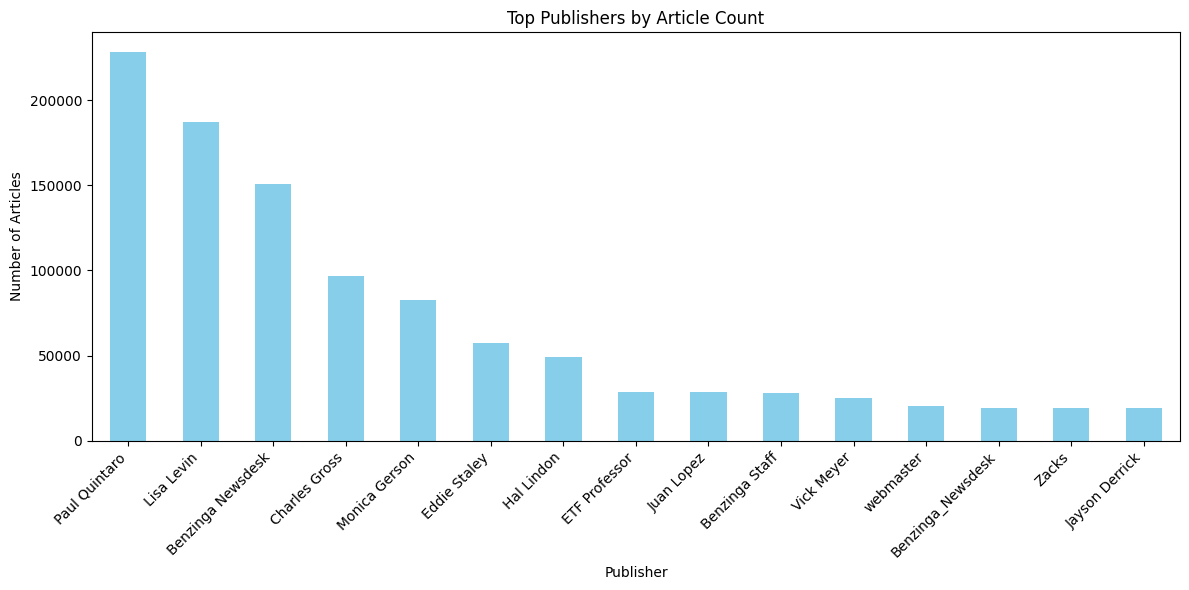

In [ ]:
from scripts.publisher_analysis import top_publishers, PublisherPlotter

top_publishers = top_publishers(df, n=15)

plotter = PublisherPlotter(top_publishers)
plotter.plot_bar()

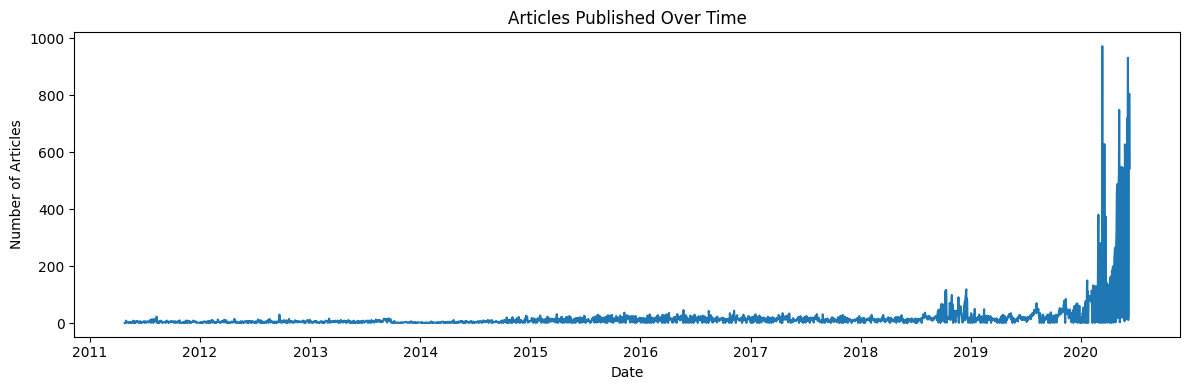

In [10]:
daily_counts = df['date'].dt.date.value_counts().sort_index()

plt.figure(figsize=(12, 4))
daily_counts.plot()
plt.title('Articles Published Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.tight_layout()
plt.show()

C:\Users\techin\AppData\Local\Temp\ipykernel_8544\291335989.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_counts.index, y=weekday_counts.values, palette="crest")


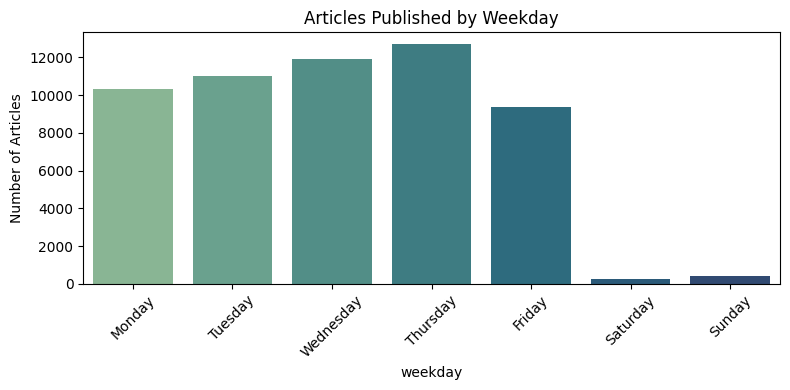

In [11]:
weekday_counts = df['weekday'].value_counts().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

plt.figure(figsize=(8, 4))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values, palette="crest")
plt.title('Articles Published by Weekday')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
df.head(5)

,Unnamed: 0,headline,url,publisher,date,stock,headline_length,weekday
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A,39,Friday
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A,42,Wednesday
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A,29,Tuesday
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A,44,Friday
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A,87,Friday


In [20]:
import re
import nltk
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\techin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
stop_words = set(stopwords.words('english'))
cleaned_headlines = []

for line in df['headline']:
    line = line.lower()
    line = re.sub(r'[^a-z\s]', '', line)  # remove punctuation/numbers
    tokens = [word for word in line.split() if word not in stop_words]
    cleaned_line = " ".join(tokens)
    cleaned_headlines.append(cleaned_line)

In [22]:
# Vectorize the text
vectorizer = TfidfVectorizer(max_df=0.9, min_df=2)
X = vectorizer.fit_transform(cleaned_headlines)

# Apply NMF
nmf_model = NMF(n_components=5, random_state=42)
nmf_model.fit(X)

# Extract feature (word) names
feature_names = vectorizer.get_feature_names_out()

# Display top 5 words from each topic
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-6:-1]]
    print(f"Topic {topic_idx + 1}: {', '.join(top_words)}")

Topic 1: vs, est, eps, reports, sales
Topic 2: stocks, moving, session, premarket, week
Topic 3: benzingas, top, upgrades, downgrades, initiations
Topic 4: scheduled, earnings, february, may, august
Topic 5: biggest, movers, yesterday, friday, set


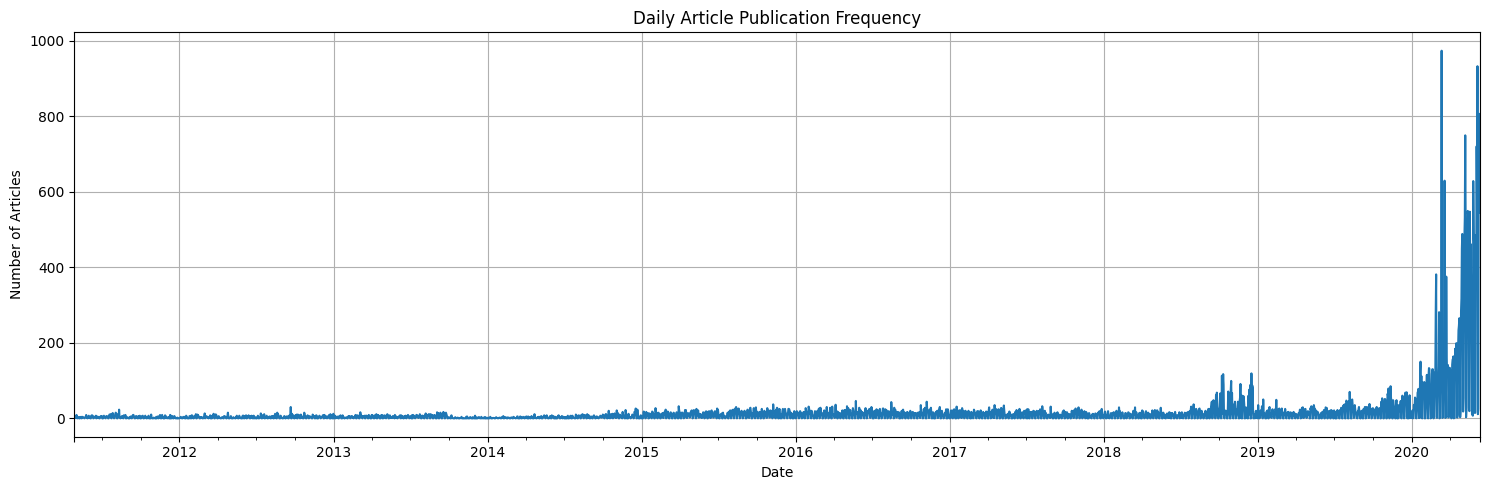

In [23]:
df.set_index('date', inplace=True)

daily_counts = df.resample('D').size()

plt.figure(figsize=(15, 5))
daily_counts.plot()
plt.title('Daily Article Publication Frequency')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
from collections import Counter
import re

def get_keywords_for_publisher(df, publisher, top_n=10):
    headlines = df[df['publisher'] == publisher]['headline'].dropna().str.lower()
    words = re.findall(r'\b\w+\b', ' '.join(headlines))
    common = Counter(words).most_common(top_n)
    return common

get_keywords_for_publisher(df, "Benzinga Insights")

[('stocks', 3119),
 ('in', 2053),
 ('market', 2052),
 ('s', 1708),
 ('pre', 1560),
 ('session', 1560),
 ('that', 1559),
 ('hit', 1559),
 ('52', 1559),
 ('week', 1559)]